# 02. Библиотека `JAX`

🎯 Основная философия и дизайн

- `PyTorch` следует императивной парадигме программирования, делая акцент на гибкости и простоте использования. Его динамический вычислительный граф позволяет интуитивно отлаживать и вносить изменения в режиме реального времени во время выполнения, что делает его очень популярным в научных исследованиях и разработках

- `JAX` построен на принципах функционального программирования, уделяя особое внимание комбинируемым преобразованиям функций (например, grad, jit, vmap). Он предоставляет API, похожий на `NumPy`, но предназначен для высокопроизводительных численных вычислений и автоматического дифференцирования

| Аспект                  | Императивное программирование                                                                             | Функциональное программирование                                                                           |
| ----------------------- | --------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------- |
| **Основная идея**       | Описывает **как** выполнять вычисления шаг за шагом (акцент на изменении состояния и управлении потоком). | Описывает **что** вычисляется (акцент на выражениях, преобразованиях данных и потоках данных).            |
| **Состояние**           | Активно используется **изменяемое состояние** (переменные могут менять значение).                         | Используется **неизменяемое состояние** — переменные не изменяются, создаются новые значения.             |
| **Выполнение**          | Команды выполняются последовательно (циклы, условные конструкции).                                        | Акцент на применении функций, рекурсии и композиции вместо явного управления потоком.                     |
| **Функции**             | Функции могут иметь **побочные эффекты** (изменять переменные, выводить на экран и т.д.).                 | Функции **чистые**: при одинаковом входе всегда возвращают один и тот же результат без побочных эффектов. |
| **Примеры конструкций** | Циклы (`for`, `while`), присваивания, условные операторы.                                                 | Функции высшего порядка (`map`, `reduce`, `filter`), рекурсия, лямбда-выражения.                          |
| **Работа с данными**    | Часто данные изменяются **на месте**.                                                                     | Данные преобразуются в новые структуры, существующие не изменяются.                                       |
| **Параллелизм**         | Труднее безопасно реализовать из-за изменяемого общего состояния.                                         | Легко реализовать, так как вычисления не зависят от общего изменяемого состояния.                         |
| **Стиль кода**          | Пошаговые инструкции, близко к работе вычислительной машины.                                              | Декларативный, математический стиль, близко к описанию задачи.                                            |

Импортируем необходимые модули

In [1]:
import matplotlib.pyplot as plt
import torch.optim       as optim
import jax.numpy         as jnp
import torch.nn          as nn
import numpy             as np

import optax
import torch
import time
import math
import jax
import os

from jax       import random, grad, value_and_grad
from tqdm.auto import tqdm

## Ключевые возможности `JAX`

#### Автодифференцирование с помощью `grad`

Автоматическое дифференцирование функций Python.

In [2]:
# A simple function
def f(x):
    return jnp.sin(x) * jnp.exp(-x)

d1f = jax.grad(f)   # derivative function

print(d1f(1.0))     # compute f'(1.0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


-0.110793784


Производные высших порядков

In [3]:
def f(x):
    return x**3

d1f = jax.grad(f  ) # first derivative
d2f = jax.grad(d1f) # second derivative

print(f  (2.0)) # compute f  (2.0)
print(d1f(2.0)) # compute f' (2.0)
print(d2f(2.0)) # compute f''(2.0)

8.0
12.0
12.0


#### Векторизация с помощью `vmap`

Автоматическая пакетная обработка функций без написания циклов.

In [3]:
# Function for a single input
def h(x):
    return x**2 + 3*x

xs = jnp.arange(5)

# Vectorize over inputs
h_vec = jax.vmap(h)
print(h_vec(xs))  # [0, 4, 10, 18, 28]

[ 0  4 10 18 28]


#### JIT-компиляция с помощью `jit`

Преобразует функции `Python` в быстрые скомпилированные исполняемые файлы `XLA`.

In [4]:
@jax.jit
def g(x):
    return jnp.dot(x, x.T) + 2.0

x = jnp.ones((1000, 1000))
print(g(x))  # Compiled & runs very fast

[[1002. 1002. 1002. ... 1002. 1002. 1002.]
 [1002. 1002. 1002. ... 1002. 1002. 1002.]
 [1002. 1002. 1002. ... 1002. 1002. 1002.]
 ...
 [1002. 1002. 1002. ... 1002. 1002. 1002.]
 [1002. 1002. 1002. ... 1002. 1002. 1002.]
 [1002. 1002. 1002. ... 1002. 1002. 1002.]]


#### Параллелизация с помощью `pmap`

Распределение вычислений между несколькими устройствами (GPU/TPU).

In [5]:
def add_one(x):
    return x + 1

# Vectorize across devices
p_add_one = jax.pmap(add_one)

xs = jnp.arange(jax.device_count())  # one per device
print(p_add_one(xs))

[1]


### Композиция `grad + jit + vmap`

In [6]:
# grad + jit + vmap
def loss_fn(w, x, y):
    preds = w * x
    return jnp.mean((preds - y)**2)

grad_loss = jax.jit(jax.vmap(jax.grad(loss_fn), in_axes=(0, None, None)))

W = jnp.array([1.0, 2.0, 3.0])   # batch of weights
x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([2.0, 4.0, 6.0])

print(grad_loss(W, x, y))  # gradients for each weight in parallel


[-9.333333  0.        9.333333]


### PyTrees: гибкие структуры данных

`JAX` может естественным образом обрабатывать вложенные словари, кортежи и списки параметров.

In [7]:
params = {"W": jnp.array([[1., 2.]]), "b": jnp.array([0.5])}

def model(params, x):
    return jnp.dot(x, params["W"].T) + params["b"]

print(model(params, jnp.array([3.0, 4.0])))

[11.5]


## Сравнение `JAX` и `PyTorch`

Сервисная функция для визуализации результатов

In [8]:
# Visualization function
def visualize_results(test_x, test_y, pred_y, losses):
    # Create the final visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: True function vs predicted function
    plt.subplot(2, 2, 1)
    plt.plot(test_x, test_y, 'r-', label='True function'     , linewidth=2)
    plt.plot(test_x, pred_y, 'b-', label='Predicted function', linewidth=2)
    plt.title('Final Prediction vs True Function')
    plt.xlabel('x')
    plt.ylabel('sin(x)')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Training loss
    plt.subplot(2, 2, 2)
    plt.plot(losses)
    plt.yscale('log')
    plt.title('Training Loss History')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.grid(True)
    
    # Plot 3: Error between true and predicted
    plt.subplot(2, 2, 3)
    error = np.abs(pred_y.flatten() - test_y)
    plt.plot(test_x, error, 'g-')
    plt.title('Absolute Error')
    plt.xlabel('x')
    plt.ylabel('|Error|')
    plt.grid(True)
    
    # Plot 4: Error distribution
    plt.subplot(2, 2, 4)
    plt.hist(error, bins=50)
    plt.title('Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
       
    # Print final statistics
    max_error  = np.max (error)
    mean_error = np.mean(error)
    print(f"Maximum error: {max_error:.6f}")
    print(f"Mean error:    {mean_error:.6f}")

Реализация процесса настройки многослойного персептрона с использованием возможностей `PyTorch`

In [9]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1,  10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10,  1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

  0%|          | 0/10000 [00:00<?, ?it/s]

Training completed!


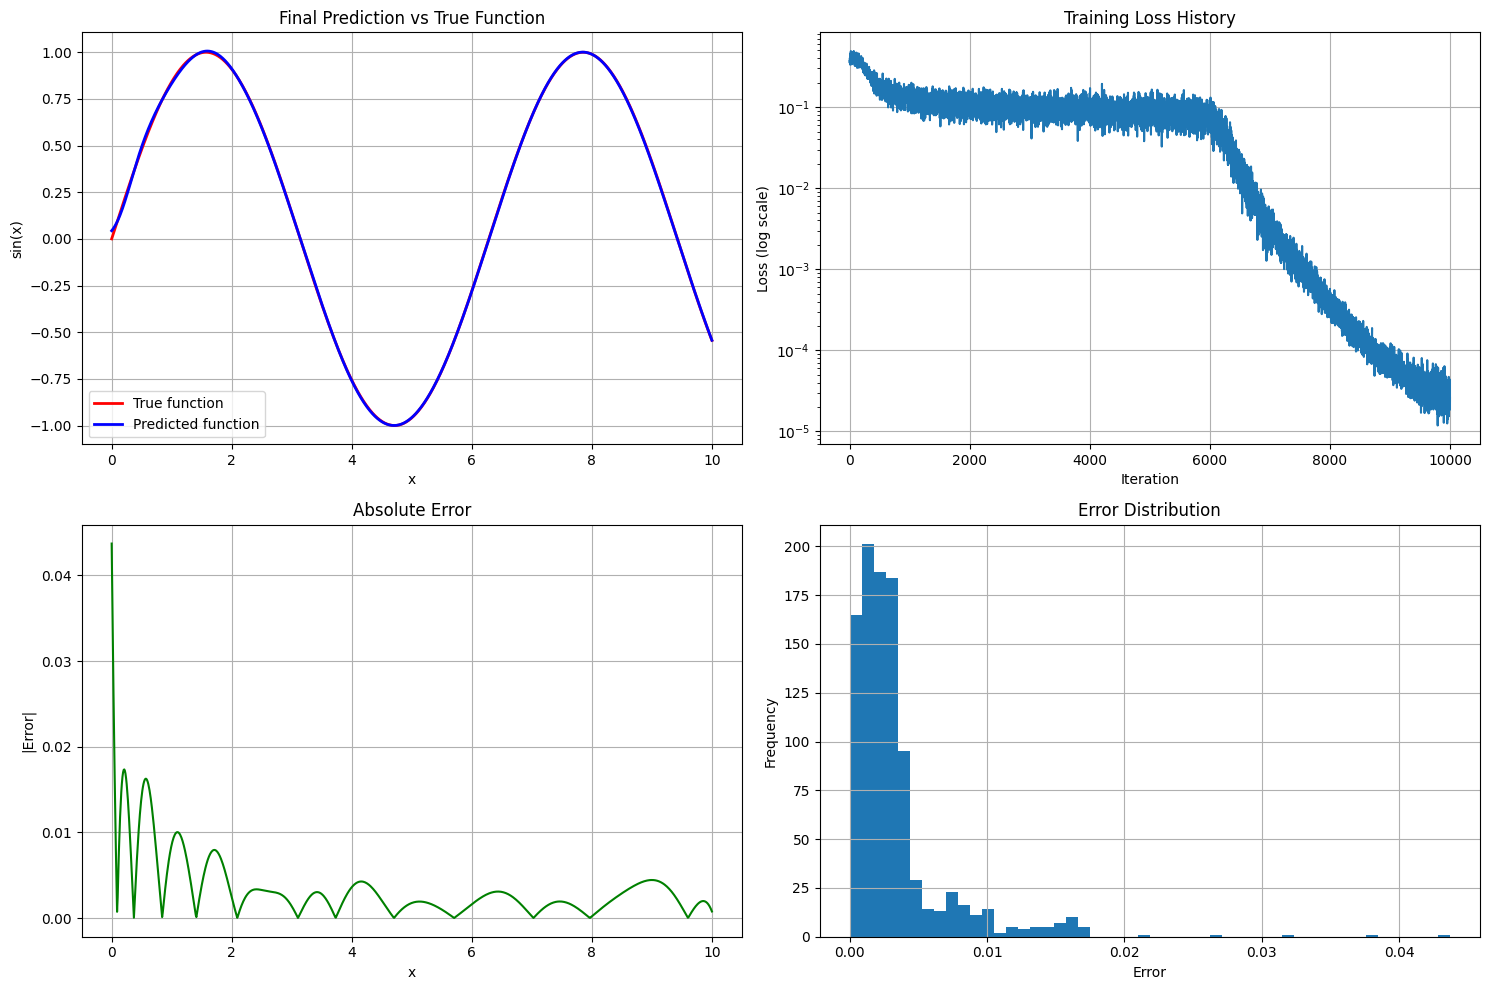

Maximum error: 0.043711
Mean error:    0.003304


In [10]:
# Initialize the network, loss function, and optimizer
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = Net().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training loop (without intermediate visualization)
losses = []
for i in tqdm(range(10000)):
    # Generate training data
    xpts = np.random.rand(100) * 10
    ypts = np.sin(xpts)
    
    # Convert to PyTorch tensors and move to device
    x_tensor = torch.tensor(xpts[:, None], dtype=torch.float32).to(device)
    y_tensor = torch.tensor(ypts[:, None], dtype=torch.float32).to(device)
    
    # Forward pass
    output = model(x_tensor)
    loss = criterion(output, y_tensor)
    losses.append(loss.item())
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Training completed!")

# Generate test data for final visualization
test_x_np = np.linspace(0, 10, 1000)
test_y_np = np.sin(test_x_np)
test_x_tensor = torch.tensor(test_x_np[:, None], dtype=torch.float32).to(device)

# Get final predictions
with torch.no_grad():
    pred_y_np = model(test_x_tensor).cpu().numpy()

visualize_results(test_x_np, test_y_np, pred_y_np, losses)

Реализация процесса настройки многослойного персептрона с использованием возможностей `JAX`

In [11]:
# Set random seed for reproducibility
key = random.PRNGKey(42)

# Define the neural network
def neural_network(params, x):
    # Unpack the parameters
    w1, b1, w2, b2, w3, b3 = params
    # Forward pass
    hidden1 = jnp.tanh(jnp.dot(x, w1) + b1)
    hidden2 = jnp.tanh(jnp.dot(hidden1, w2) + b2)
    output  = jnp.dot(hidden2, w3) + b3
    return output

# Initialize parameters
def init_params(layer_sizes, key):
    keys = random.split(key, len(layer_sizes))
    params = []
    for i in range(len(layer_sizes)-1):
        w = random.normal(keys[i], (layer_sizes[i], layer_sizes[i+1])) * jnp.sqrt(2/layer_sizes[i])
        b = jnp.zeros((layer_sizes[i+1],))
        params.append(w)
        params.append(b)
    return params

# Define the loss function
def loss_fn(params, x, y):
    predictions = neural_network(params, x)
    return jnp.mean((predictions - y)**2)

  0%|          | 0/10000 [00:00<?, ?it/s]

Training completed!


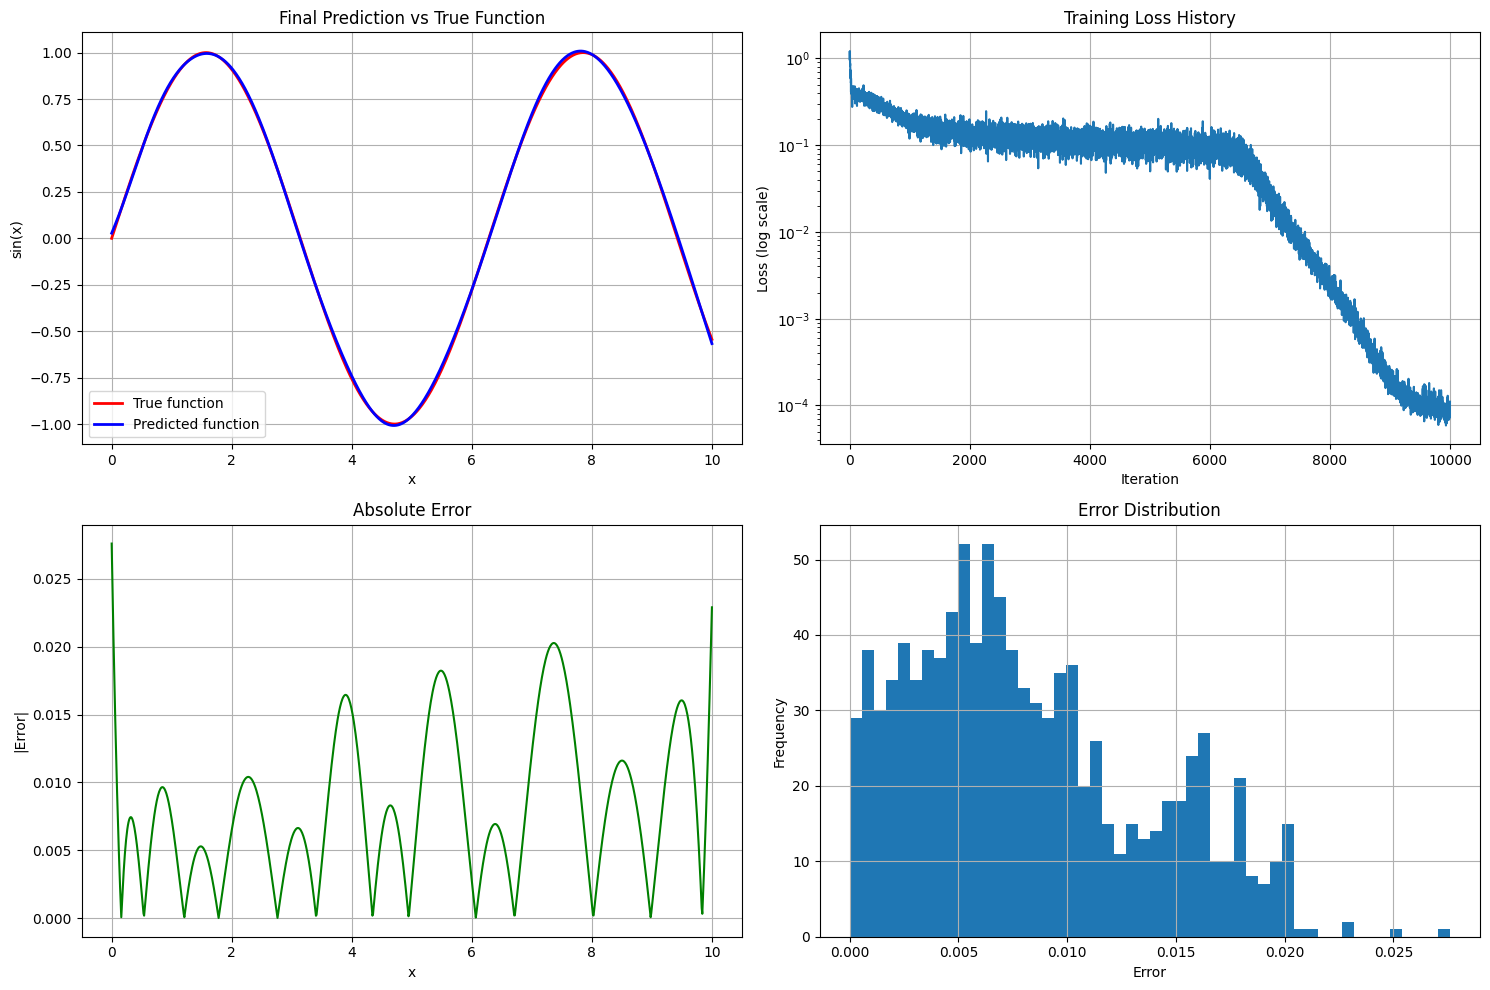

Maximum error: 0.027606
Mean error:    0.008142


In [12]:
# Initialize the model
layer_sizes = [1, 10, 10, 1]
params = init_params(layer_sizes, key)

# Set up optimizer
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

# Training function
@jax.jit
def train_step(params, opt_state, x, y):
    loss, grads = value_and_grad(loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Training loop
losses = []
for i in tqdm(range(10000)):
    # Generate training data
    xpts = np.random.rand(100) * 10
    ypts = np.sin(xpts)
    
    # Convert to JAX arrays
    x_batch = jnp.reshape(jnp.array(xpts), (100, 1))
    y_batch = jnp.reshape(jnp.array(ypts), (100, 1))
    
    # Training step
    params, opt_state, loss = train_step(params, opt_state, x_batch, y_batch)
    losses.append(loss)

print("Training completed!")

# Generate test data for visualization
test_x = np.linspace(0, 10, 1000)
test_y = np.sin(test_x)
test_x_jax = jnp.reshape(jnp.array(test_x), (1000, 1))

# Make predictions
@jax.jit
def predict(params, x):
    return neural_network(params, x)

pred_y = predict(params, test_x_jax)

# Convert to numpy for visualization
test_x_np = np.array(test_x)
test_y_np = np.array(test_y)
pred_y_np = np.array(pred_y).flatten()

visualize_results(test_x_np, test_y_np, pred_y_np, losses)